In [79]:
#Japkirat Singh
#102015030
#ENC2

In [2]:
!wget https://unsplash-datasets.s3.amazonaws.com/lite/latest/unsplash-research-dataset-lite-latest.zip

--2023-05-01 16:36:26--  https://unsplash-datasets.s3.amazonaws.com/lite/latest/unsplash-research-dataset-lite-latest.zip
Resolving unsplash-datasets.s3.amazonaws.com (unsplash-datasets.s3.amazonaws.com)... 3.5.24.139, 52.216.98.171, 52.217.78.20, ...
Connecting to unsplash-datasets.s3.amazonaws.com (unsplash-datasets.s3.amazonaws.com)|3.5.24.139|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 632351052 (603M) [application/zip]
Saving to: ‘unsplash-research-dataset-lite-latest.zip’

unsplash-research-d 100%[===================>] 603.06M  13.0MB/s    in 49s     

2023-05-01 16:37:17 (12.3 MB/s) - ‘unsplash-research-dataset-lite-latest.zip’ saved [632351052/632351052]



In [13]:
!unzip unsplash-research-dataset-lite-latest.zip

Archive:  unsplash-research-dataset-lite-latest.zip
replace collections.tsv000? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: collections.tsv000      
  inflating: __MACOSX/._collections.tsv000  
  inflating: colors.tsv000           
  inflating: __MACOSX/._colors.tsv000  
  inflating: conversions.tsv000      
  inflating: __MACOSX/._conversions.tsv000  
  inflating: DOCS.md                 
  inflating: keywords.tsv000         
  inflating: __MACOSX/._keywords.tsv000  
  inflating: photos.tsv000           
  inflating: __MACOSX/._photos.tsv000  
  inflating: README.md               
  inflating: TERMS.md                


In [8]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [12]:
!cp -r /content/drive/MyDrive/unsplash-dataset /content/

cp: cannot stat '/content/drive/MyDrive/unsplash-dataset': No such file or directory


In [14]:
!git clone https://github.com/openai/CLIP

Cloning into 'CLIP'...
remote: Enumerating objects: 243, done.
remote: Total 243 (delta 0), reused 0 (delta 0), pack-reused 243
Receiving objects: 100% (243/243), 8.92 MiB | 9.60 MiB/s, done.
Resolving deltas: 100% (124/124), done.


In [15]:
!pip install ftfy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 7.6 MB/s eta 0:00:00


In [16]:
import sys

CLIP_DIR = "CLIP"
sys.path.append(CLIP_DIR)

In [18]:
import clip

In [19]:
import torch
from PIL import Image
from tqdm.notebook import tqdm
import numpy as np

In [20]:
import csv

In [21]:
photo_urls = []
with open("photos.tsv000") as fIn:
    reader = csv.DictReader(fIn, delimiter='\t')
    for row in tqdm(reader):
        photo_urls.append([row['photo_id'], row['photo_image_url']])

print(f'Photos in the dataset: {len(photo_urls)}')

0it [00:00, ?it/s]

Photos in the dataset: 25000


In [22]:
from pathlib import Path

dataset_version = "lite"
unsplash_dataset_path = Path("unsplash-dataset") / dataset_version

In [23]:
import urllib.request

photos_download_path = unsplash_dataset_path / "photos"

def download_photo(photo):
    photo_id = photo[0]
    # Get the URL of the photo (setting the width to 640 pixels)
    photo_url = photo[1] + "?w=640"
    photo_path = photos_download_path / (photo_id + ".jpg")
    if not photo_path.exists():
        try:
            urllib.request.urlretrieve(photo_url, photo_path)
        except Exception as e:
            print(f"Cannot download {photo_url}", e)
            pass

In [24]:
photos_download_path.mkdir(parents=True)

In [25]:
from multiprocessing.pool import ThreadPool

# Create the thread pool
threads_count = 256
pool = ThreadPool(threads_count)

In [26]:
# Start the download
ret = pool.map(download_photo, photo_urls)

Cannot download https://images.unsplash.company%20by%20Alessandro%20Desantis%20-%20Downloaded%20from%20500px_jpg.jpg?w=640 URL can't contain control characters. 'images.unsplash.company by Alessandro Desantis - Downloaded from 500px_jpg.jpg' (found at least ' ')
Cannot download https://images.unsplash.com/photo-1578411246981-e0394f597159?w=640 HTTP Error 404: Not Found
Cannot download https://images.unsplash.com/photo-1498144846853-60ca2d43853b?w=640 HTTP Error 404: Not Found
Cannot download https://images.unsplash.com_TheBeach.jpg?w=640 <urlopen error [Errno -2] Name or service not known>
Cannot download https://images.unsplash.com/photo-1578166671353-7978081a6f9c?w=640 HTTP Error 404: Not Found
Cannot download https://images.unsplash.com-grass-sun.jpg?w=640 <urlopen error [Errno -2] Name or service not known>
Cannot download https://images.unsplash.com/photo-1583307709837-2d0e3a82be15?w=640 HTTP Error 404: Not Found
Cannot download https://images.unsplash.com/photo-1573486145949-1821

In [27]:
photos_files = list(photos_download_path.glob("*.jpg"))
print(f'Photos downloaded: {len(photos_files)}')

Photos downloaded: 24992


In [28]:
!zip -r -q /content/unsplash-dataset.zip /content/unsplash-dataset/

In [29]:
!cp /content/unsplash-dataset.zip /content/drive/MyDrive/

In [30]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [31]:
model, preprocess = clip.load("ViT-B/32", device=device)

100%|████████████████████████████████████████| 338M/338M [00:01<00:00, 247MiB/s]


In [32]:
photos_files[0], photo_urls[0]

(PosixPath('unsplash-dataset/lite/photos/Px1DLXKhzNc.jpg'),
 ['XMyPniM9LF0',
  'https://images.unsplash.com/uploads/14119492946973137ce46/f1f2ebf3'])

In [33]:
id_url_dict = {}
def assign(x):
    id_url_dict[x[0]]=x[1]
ret = list(map(assign, photo_urls))

In [34]:
def process_batch(photo_batch):
    images = []
    batch_photo_ids = []
    for pf in photo_batch:
        images.append(preprocess(Image.open(pf)))
        batch_photo_ids.append(pf.name.split('.jpg')[0])
    images_tensor = torch.stack(images).to(device)
    with torch.no_grad():
        images_features = model.encode_image(images_tensor)
        images_features /= images_features.norm(dim=-1, keepdim=True)
    return images_features.cpu(), batch_photo_ids

In [35]:
BATCH_SIZE = 256
images_embeddings = []
photo_ids = []

for i in tqdm(range(0, len(photos_files), BATCH_SIZE)):
    images_features, batch_photo_ids = process_batch(photos_files[i:i+BATCH_SIZE])
    photo_ids.extend(batch_photo_ids)
    images_embeddings.append(images_features)

  0%|          | 0/98 [00:00<?, ?it/s]

In [74]:
#images_embeddings = torch.cat(images_embeddings)

In [45]:
images_embeddings.shape, len(photo_ids)

(torch.Size([24992, 512]), 24992)

In [46]:
torch.save(images_embeddings, 'images_embeddings.pt')

In [47]:
images_embeddings = torch.load('images_embeddings.pt')

In [48]:
import pickle

In [51]:
 with open('photo_ids.list', 'wb') as fp:
     pickle.dump(photo_ids, fp)

In [52]:
with open('photo_ids.list', 'rb') as fp:
    photo_ids = pickle.load(fp)

In [53]:
images_embeddings.shape, len(photo_ids)

(torch.Size([24992, 512]), 24992)

In [54]:
images_embeddings = images_embeddings.to(device)

In [55]:
def get_sim(inp_q=["sun rising"]):
    with torch.no_grad():
        text = clip.tokenize(inp_q)
        text = text.to(device)
        text_features = model.encode_text(text)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        logit_scale = 100#model.logit_scale.exp()
        logits_per_image = (logit_scale * images_embeddings @ text_features.t()).squeeze()
        logits_per_image = logits_per_image.cpu().numpy()
    return logits_per_image

In [56]:
text = clip.tokenize(["sun rising"]).to(device)

In [57]:
model, preprocess = clip.load("ViT-B/32", device=device)

In [58]:
with torch.no_grad():
    text_features = model.encode_text(text)

In [66]:
text_features[0,:20]

tensor([-0.1152, -0.0975, -0.1477,  0.0673, -0.0724,  0.0407, -0.1158, -1.4199,
        -0.0330,  0.3938, -0.0036, -0.0786, -0.2240, -0.4224, -0.2498,  0.0896,
        -0.0255,  0.3701, -0.0875,  0.2705], device='cuda:0',
       dtype=torch.float16)

In [67]:
text_features[0,:20]

tensor([-0.1152, -0.0975, -0.1477,  0.0673, -0.0724,  0.0407, -0.1158, -1.4199,
        -0.0330,  0.3938, -0.0036, -0.0786, -0.2240, -0.4224, -0.2498,  0.0896,
        -0.0255,  0.3701, -0.0875,  0.2705], device='cuda:0',
       dtype=torch.float16)

In [75]:
logits_per_image = get_sim(["dog"])
logits_per_image[:20]

array([17.84, 19.44, 19.33, 20.02, 19.78, 18.02, 19.75, 20.33, 20.58,
       19.44, 19.8 , 17.94, 18.55, 17.75, 18.  , 17.39, 17.47, 18.5 ,
       18.72, 18.67], dtype=float16)

In [76]:
logits_per_image[:20]

array([17.84, 19.44, 19.33, 20.02, 19.78, 18.02, 19.75, 20.33, 20.58,
       19.44, 19.8 , 17.94, 18.55, 17.75, 18.  , 17.39, 17.47, 18.5 ,
       18.72, 18.67], dtype=float16)

In [77]:
best_photo_idx = np.argsort(logits_per_image)[::-1]
best_photos = [(logits_per_image[i],i) for i in best_photo_idx]
best_photos[:5]

[(30.25, 15293), (30.2, 243), (29.98, 6669), (29.45, 22284), (29.08, 4861)]

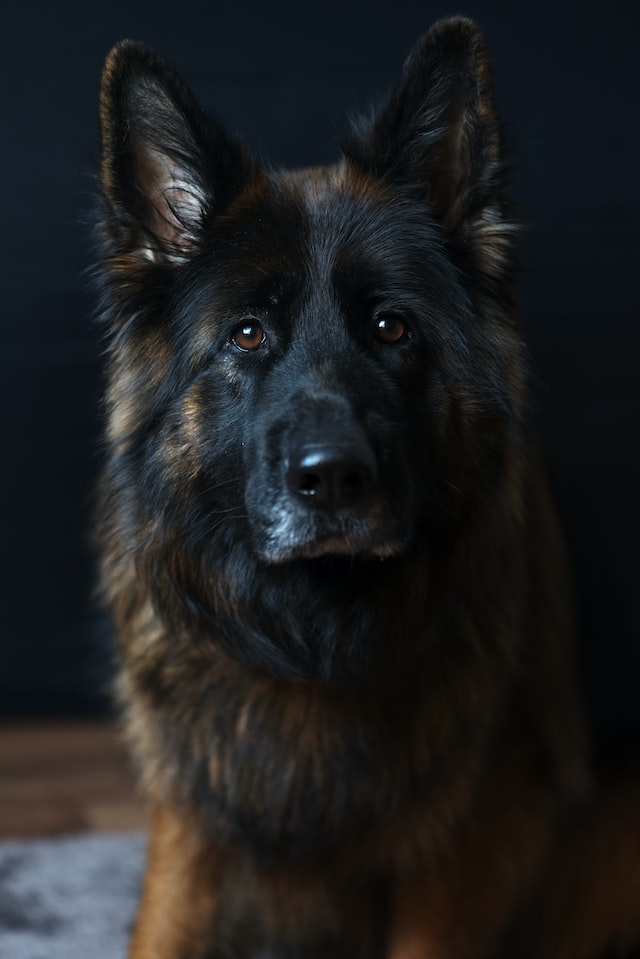

In [78]:
Image.open(photos_download_path / (photo_ids[best_photo_idx[0]] + ".jpg"))